In [ ]:
# @title ⚙️ Runtime Specifications
import platform
import psutil
import os
import sys
import torch
import tensorflow

def get_size(bytes_val, suffix="B"):
    """Scale bytes to its proper format (e.g., 1024 -> 1KB)."""
    if bytes_val is None:
        return "N/A"

    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes_val < factor:
            # Ensure the value is converted to float for proper division and formatting
            return f"{float(bytes_val):.2f}{unit}{suffix}"
        bytes_val /= factor

print("--- System and Environment ---")
print(f"OS/Platform: {platform.system()} ({platform.release()})")
print(f"Kernel Version: {platform.version()}")
print(f"Python Version: {sys.version.split()[0]} ({platform.architecture()[0]})")
print(f"PyTorch Version: {torch.__version__}")
print(f"TensorFlow Version: {tensorflow.__version__}")
print()

print("--- CPU and System RAM ---")
print("CPU Details (from `!lscpu`): ")
!lscpu | grep 'Model name\|Socket(s)\|Core(s) per socket\|Thread(s) per core\|CPU MHz'
mem = psutil.virtual_memory()
print(f"System RAM: {get_size(mem.total)}")
print()

# Check for GPU (CUDA)
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    device_props = torch.cuda.get_device_properties(0)
    print("--- Accelerator: GPU (CUDA) ---")
    print(f"Device Name: {device_name}")
    print(f"CUDA Cores: {device_props.multi_processor_count * 64} (Approx)")
    print(f"Global Memory: {get_size(device_props.total_memory)}")
    print(f"CUDA Capability: {device_props.major}.{device_props.minor}")
if 'TPU_NAME' in os.environ:
    print("--- Accelerator: TPU ---")
    print(f"**TPU Name:** {os.environ['TPU_NAME']}")

--- System and Environment ---
OS/Platform: Linux (6.6.105+)
Kernel Version: #1 SMP Thu Oct  2 10:42:05 UTC 2025
Python Version: 3.12.12 (64bit)
PyTorch Version: 2.9.0+cu126
TensorFlow Version: 2.19.0

--- CPU and System RAM ---
CPU Details (from `!lscpu`): 
Model name:                              Intel(R) Xeon(R) CPU @ 2.00GHz
Thread(s) per core:                      2
Core(s) per socket:                      1
Socket(s):                               1
System RAM: 12.67GB

--- Accelerator: GPU (CUDA) ---
Device Name: Tesla T4
CUDA Cores: 2560 (Approx)
Global Memory: 14.74GB
CUDA Capability: 7.5


# 1. Configuration & Helper Functions

We define a standardized benchmarking function to ensure fair comparison across all formats. This function measures:

1. Loading Time: Time taken to read data from disk into RAM.
2. Training Time: Time taken to vectorize text and train the model.
3. Peak Memory: Maximum RAM usage during the process.
4. Performance: Accuracy and F1 Score.

In [ ]:
# @title 1.1 Setup & Dependencies
# Install necessary libraries for the benchmark and SchemaForge
!pip install -q datasets pandas scikit-learn matplotlib seaborn psutil pyarrow fastavro ijson

import os
import sys
import time
import psutil
import shutil
import subprocess
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# Configure plotting
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Environment setup complete.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 15.8 MB/s eta 0:00:00
✅ Environment setup complete.


In [ ]:
# @title 1.2 Define Benchmarking Utilities

class BenchmarkTracker:
    def __init__(self):
        self.results = []

    def measure(self, format_name, load_func, train_func):
        """
        Generic function to measure load and train performance.
        """
        print(f"--- Benchmarking: {format_name} ---")

        process = psutil.Process(os.getpid())
        mem_before = process.memory_info().rss / (1024 * 1024)

        # --- Measure Loading ---
        print(f"   ⏳ Loading data...")
        start_load = time.perf_counter()
        X_train, y_train, X_test, y_test = load_func()
        end_load = time.perf_counter()
        load_time = end_load - start_load
        print(f"   ✅ Loaded {len(y_train):,} rows in {load_time:.2f}s")

        # --- Measure Training ---
        print(f"   ⚙️  Training model...")
        start_train = time.perf_counter()
        model = train_func(X_train, y_train)
        end_train = time.perf_counter()
        train_time = end_train - start_train

        # --- Measure Memory Peak ---
        mem_after = process.memory_info().rss / (1024 * 1024)
        peak_memory_usage = max(0, mem_after - mem_before)

        # --- Evaluate ---
        # Predict on a subset of test data to save inference time in benchmark
        subset_test_size = 10000
        y_pred = model.predict(X_test[:subset_test_size])
        acc = accuracy_score(y_test[:subset_test_size], y_pred)
        f1 = f1_score(y_test[:subset_test_size], y_pred, average='weighted')

        print(f"   ⏱️ Train Time: {train_time:.4f}s")
        print(f"   💾 Mem Delta: {peak_memory_usage:.2f} MB")
        print("-" * 30)

        self.results.append({
            "Format": format_name,
            "Load Time (s)": load_time,
            "Training Time (s)": train_time,
            "Total Time (s)": load_time + train_time,
            "Peak Memory Delta (MB)": peak_memory_usage,
            "Accuracy": acc,
            "F1 Score": f1
        })

    def get_summary(self):
        return pd.DataFrame(self.results)

# Initialize tracker
tracker = BenchmarkTracker()

# OPTIMIZED Model Architecture for Large Datasets
from sklearn.linear_model import SGDClassifier

def train_standard_model(X_train, y_train):
    """
    Pipeline: TF-IDF + SGDClassifier.
    SGDClassifier is much faster for large datasets (1M+ rows) than standard LogisticRegression.
    """
    model = make_pipeline(
        # Limit features to keep memory usage stable during vectorization
        TfidfVectorizer(max_features=10000, stop_words='english'),
        # Log loss = Logistic Regression via SGD
        SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, n_jobs=-1, random_state=42)
    )
    model.fit(X_train, y_train)
    return model

print("✅ Benchmarking utilities ready.")

✅ Benchmarking utilities ready.


In [ ]:
# @title 1.3 Define Global Constants and Paths

# Dataset Configuration
DATASET_NAME = "amazon_polarity"
TRAIN_SPLIT = "train"
TEST_SPLIT = "test"

# Directory and File Paths
SCHEMA_BENCH_ROOT = "schemaforge_bench"
DATA_DIR = os.path.join(SCHEMA_BENCH_ROOT, "data")
OUTPUT_DIR = os.path.join(SCHEMA_BENCH_ROOT, "output")
SCHEMA_REPORT_PREFIX = os.path.join(SCHEMA_BENCH_ROOT, "schema_report")
SCHEMA_REPORT_PATH = f"{SCHEMA_REPORT_PREFIX}.json"

# Create necessary directories
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("✅ Global constants and paths defined.")

✅ Global constants and paths defined.


# 2. Baseline: Hugging Face datasets

We use the AG News dataset (Text Classification). We load it directly using the Hugging Face datasets library, which relies on Arrow format internally (memory-mapped), usually providing a very fast baseline.

In [ ]:
# @title 2.1 Benchmark Hugging Face Baseline

# Ensure data is cached locally before benchmarking to exclude network effects
cached_dataset = load_dataset(DATASET_NAME, split=TRAIN_SPLIT)
cached_test_dataset = load_dataset(DATASET_NAME, split=TEST_SPLIT)

# Free up the cached variable immediately to prevent affecting the Baseline benchmark's result
del cached_dataset
del cached_test_dataset
gc.collect()

def load_hf_baseline():
    """
    Loads a subset of the Amazon Polarity dataset using Hugging Face datasets
    for benchmarking purposes.
    """
    dataset = load_dataset(DATASET_NAME, split=TRAIN_SPLIT)
    test_dataset = load_dataset(DATASET_NAME, split=TEST_SPLIT)

    df_train = dataset.to_pandas()
    df_test = test_dataset.to_pandas()

    return df_train['content'], df_train['label'], df_test['content'], df_test['label']

# Run Baseline
tracker.measure(
    format_name="HF Dataset (Arrow)",
    load_func=load_hf_baseline,
    train_func=train_standard_model
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

amazon_polarity/train-00000-of-00004.par(…):   0%|          | 0.00/260M [00:00<?, ?B/s]

amazon_polarity/train-00001-of-00004.par(…):   0%|          | 0.00/258M [00:00<?, ?B/s]

amazon_polarity/train-00002-of-00004.par(…):   0%|          | 0.00/255M [00:00<?, ?B/s]

amazon_polarity/train-00003-of-00004.par(…):   0%|          | 0.00/254M [00:00<?, ?B/s]

amazon_polarity/test-00000-of-00001.parq(…):   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

--- Benchmarking: HF Dataset (Arrow) ---
   ⏳ Loading data...
   ✅ Loaded 3,600,000 rows in 6.28s
   ⚙️  Training model...
   ⏱️ Train Time: 174.5190s
   💾 Mem Delta: 2250.99 MB
------------------------------


# 3. Setup SchemaForge & Convert Data

Now we clone SchemaForge, prepare the input JSON data (simulating a raw data ingestion scenario), and use the tool to generate CSV, Parquet, and Feather files.

In [ ]:
# @title 3.1 Prepare Input Data for SchemaForge
# SchemaForge requires raw JSON files as input.
# We will export the HF dataset to a raw JSON format to simulate the "Chaos" state.

print("📥 Loading raw dataset for export (this may take a minute)... ")
# Use the predefined constants for dataset name and splits
raw_data = load_dataset(DATASET_NAME, split=TRAIN_SPLIT)
test_data = load_dataset(DATASET_NAME, split=TEST_SPLIT)

print("💾 Saving training data to JSON Lines (NDJSON)...")
# Using lines=True (NDJSON) is much more memory efficient for 1M+ rows
raw_data.to_json(os.path.join(DATA_DIR, "train_data.json"), orient="records", lines=True)

print("💾 Saving test data to JSON Lines (NDJSON)...")
test_data.to_json(os.path.join(DATA_DIR, "test_data.json"), orient="records", lines=True)

# Free up memory immediately
del raw_data
del test_data
gc.collect()

print(f"✅ Data exported to JSON in '{DATA_DIR}'")

📥 Loading raw dataset for export (this may take a minute)... 
💾 Saving training data to JSON Lines (NDJSON)...


Creating json from Arrow format:   0%|          | 0/3600 [00:00<?, ?ba/s]

💾 Saving test data to JSON Lines (NDJSON)...


Creating json from Arrow format:   0%|          | 0/400 [00:00<?, ?ba/s]

✅ Data exported to JSON in 'schemaforge_bench/data'


In [ ]:
# @title 3.2 Clone SchemaForge
!git clone https://github.com/Syntax-Error-1337/SchemaForge.git schemaforge_tool --depth 1
!cd schemaforge_tool && pip install -r requirements.txt

Cloning into 'schemaforge_tool'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 46 (delta 5), reused 30 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (46/46), 41.65 KiB | 2.78 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
# @title 3.3 Run SchemaForge Pipeline (Scan & Convert)

# 1. Scan Schemas
# We run from inside 'SchemaForge', so we point to data using relative paths from schemaforge_tool
print("🔍 Running SchemaForge: scan-schemas...")
!cd schemaforge_tool && python -m src.cli scan-schemas \
    --data-dir ../{DATA_DIR} \
    --output-report ../{SCHEMA_REPORT_PREFIX}.md

# 2. Convert to CSV
print("🔄 Converting to CSV...")
!cd schemaforge_tool && python -m src.cli convert \
    --format csv \
    --data-dir ../{DATA_DIR} \
    --output-dir ../{OUTPUT_DIR}/csv \
    --schema-report ../{SCHEMA_REPORT_PATH}

# 3. Convert to Parquet
print("🔄 Converting to Parquet...")
!cd schemaforge_tool && python -m src.cli convert \
    --format parquet \
    --data-dir ../{DATA_DIR} \
    --output-dir ../{OUTPUT_DIR}/parquet \
    --schema-report ../{SCHEMA_REPORT_PATH}

# 4. Convert to Feather (Fast I/O)
print("🔄 Converting to Feather...")
!cd schemaforge_tool && python -m src.cli convert \
    --format feather \
    --data-dir ../{DATA_DIR} \
    --output-dir ../{OUTPUT_DIR}/feather \
    --schema-report ../{SCHEMA_REPORT_PATH}

print(f"\n✅ Conversion Complete! Formats ready in '{OUTPUT_DIR}/'")

🔍 Running SchemaForge: scan-schemas...
2025-12-08 18:46:04,545 - __main__ - INFO - Starting schema scan...
2025-12-08 18:46:04,546 - src.schema_reader.inference - INFO - Found 2 JSON file(s) in ../schemaforge_bench/data
2025-12-08 18:46:04,572 - src.schema_reader.inference - INFO - Processing file: train_data.json
2025-12-08 18:46:04,573 - src.schema_reader.inference - INFO - No max_sample_size set. Defaulting to 10000 for performance.
2025-12-08 18:46:04,574 - src.schema_reader.inference - INFO - Processing file: test_data.json
2025-12-08 18:46:04,575 - src.schema_reader.inference - INFO - No max_sample_size set. Defaulting to 10000 for performance.
2025-12-08 18:46:05,067 - src.json_loader - WARNING - Streaming failed for ../schemaforge_bench/data/test_data.json: Extra data: line 2 column 1 (char 569). Falling back to memory load.
2025-12-08 18:46:10,694 - src.json_loader - WARNING - Streaming failed for ../schemaforge_bench/data/train_data.json: Extra data: line 2 column 1 (char 460

# 4. Benchmark Converted Formats

Now we benchmark the loading and training efficiency for the formats generated by SchemaForge.

In [ ]:
# @title 4.1 Benchmark CSV

def load_csv_format():
    # Load Train
    df_train = pd.read_csv(os.path.join(OUTPUT_DIR, "csv", "train_data.csv"))
    # Load Test
    df_test = pd.read_csv(os.path.join(OUTPUT_DIR, "csv", "test_data.csv"))

    return df_train['content'], df_train['label'], df_test['content'], df_test['label']

tracker.measure(
    format_name="CSV (Pandas)",
    load_func=load_csv_format,
    train_func=train_standard_model
)

--- Benchmarking: CSV (Pandas) ---
   ⏳ Loading data...
   ✅ Loaded 3,600,000 rows in 34.78s
   ⚙️  Training model...
   ⏱️ Train Time: 176.3890s
   💾 Mem Delta: 2298.81 MB
------------------------------


In [ ]:
# @title 4.2 Benchmark Parquet

def load_parquet_format():
    # Load Train
    df_train = pd.read_parquet(os.path.join(OUTPUT_DIR, "parquet", "train_data.parquet"))
    # Load Test
    df_test = pd.read_parquet(os.path.join(OUTPUT_DIR, "parquet", "test_data.parquet"))

    return df_train['content'], df_train['label'], df_test['content'], df_test['label']

tracker.measure(
    format_name="Parquet (PyArrow)",
    load_func=load_parquet_format,
    train_func=train_standard_model
)

--- Benchmarking: Parquet (PyArrow) ---
   ⏳ Loading data...
   ✅ Loaded 3,600,000 rows in 13.88s
   ⚙️  Training model...
   ⏱️ Train Time: 180.0725s
   💾 Mem Delta: 2028.25 MB
------------------------------


In [ ]:
# @title 4.3 Benchmark Feather

def load_feather_format():
    # Load Train
    df_train = pd.read_feather(os.path.join(OUTPUT_DIR, "feather", "train_data.feather"))
    # Load Test
    df_test = pd.read_feather(os.path.join(OUTPUT_DIR, "feather", "test_data.feather"))

    return df_train['content'], df_train['label'], df_test['content'], df_test['label']

tracker.measure(
    format_name="Feather (Arrow IPC)",
    load_func=load_feather_format,
    train_func=train_standard_model
)

--- Benchmarking: Feather (Arrow IPC) ---
   ⏳ Loading data...
   ✅ Loaded 3,600,000 rows in 9.55s
   ⚙️  Training model...
   ⏱️ Train Time: 175.7252s
   💾 Mem Delta: 2329.90 MB
------------------------------


# 5. Analysis & Visualization

We aggregate the results into a clean DataFrame and visualize the trade-offs between load time, memory usage, and storage efficiency.

In [ ]:
# @title 5.1 Results Summary
results_df = tracker.get_summary()

# Normalize columns for better visualization comparison if needed,
# but raw values are usually better for technical benchmarks.
display(results_df.round(4))

,Format,Load Time (s),Training Time (s),Total Time (s),Peak Memory Delta (MB),Accuracy,F1 Score
0,HF Dataset (Arrow),6.2827,174.5190,180.8017,2250.9883,0.8397,0.8396
1,CSV (Pandas),34.7801,176.3890,211.1692,2298.8125,0.8397,0.8396
2,Parquet (PyArrow),13.8773,180.0725,193.9499,2028.2461,0.8397,0.8396
3,Feather (Arrow IPC),9.5521,175.7252,185.2773,2329.9023,0.8397,0.8396


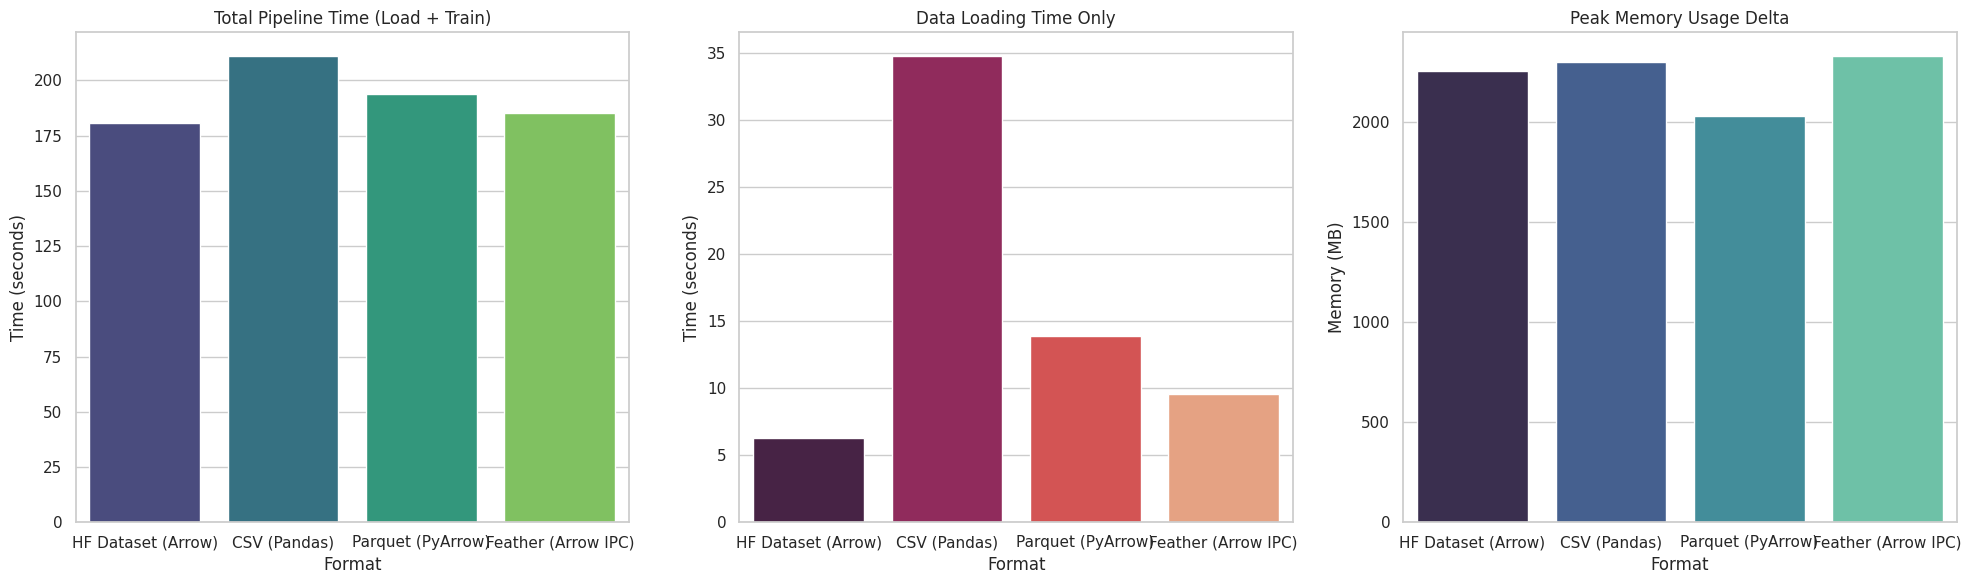

In [ ]:
# @title 5.2 Visualizing the Benchmark
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Total Time Comparison (Load + Train)
sns.barplot(
    data=results_df,
    x="Format",
    y="Total Time (s)",
    ax=axes[0],
    palette="viridis",
    hue="Format",
    legend=False
)
axes[0].set_title("Total Pipeline Time (Load + Train)")
axes[0].set_ylabel("Time (seconds)")

# 2. Loading Time Only (Zoom in on I/O efficiency)
sns.barplot(
    data=results_df,
    x="Format",
    y="Load Time (s)",
    ax=axes[1],
    palette="rocket",
    hue="Format",
    legend=False
)
axes[1].set_title("Data Loading Time Only")
axes[1].set_ylabel("Time (seconds)")

# 3. Memory Footprint
sns.barplot(
    data=results_df,
    x="Format",
    y="Peak Memory Delta (MB)",
    ax=axes[2],
    palette="mako",
    hue="Format",
    legend=False
)
axes[2].set_title("Peak Memory Usage Delta")
axes[2].set_ylabel("Memory (MB)")

plt.tight_layout()
plt.show()